In [67]:
import copy
import numpy as np
import pandas as pd

from src.common.functions import get_feature_importance
%cd /home/heza7322/PycharmProjects/missing-value-handling-in-carts
#%cd /Users/Henning/PycharmProjects/missing-value-handling-in-carts
import matplotlib.pyplot as plt
from src.binary_tree import BinaryTree
from src.trinary_tree import TrinaryTree
from src.weighted_tree import WeightedTree
from src.common.functions import get_indices, calculate_loss, fit_response

data_folder = 'example_notebooks/data_cleaned/'
file_name = 'lymphography.csv'

/home/heza7322/PycharmProjects/missing-value-handling-in-carts


In [68]:
# Load data and confirm dtypes
df = pd.read_csv(data_folder+file_name,index_col = 0)
features = [column for column in df.columns if column!='y']
if file_name == 'zoo.csv':
    df[df.columns[:-1]] = df[df.columns[:-1]].astype(float)

df.dtypes

y                     object
lymphatics            object
block_of_affere       object
block_of_lymph_c      object
block_of_lymph_s      object
by_pass               object
extravasates          object
regeneration          object
early_uptake          object
lymph_nodes_dimin    float64
lymph_nodes_enlar    float64
chamges_in_lymph      object
defect_in_node        object
change_in_node        object
changes_in_stru       object
special_forms         object
dislocation           object
exclusion             object
n_nodes              float64
dtype: object

In [69]:
# Test train split
n = len(df)
df['test'] = False
index_train = np.random.choice(df.index,int(n*0.2))
df.loc[index_train,'test'] = True

# Set up trees
max_depth = 2
min_samples_leaf = int(n*0.8/10)
tree_types = {'majority': BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='majority'),
              'mia':      BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='mia'),
              'trinary':  TrinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf),
              'weighted': WeightedTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)}

In [70]:
# Missingness of different frequencies
missing_probs = [0,0.25,0.5,0.75]

dfs = {0: df.copy()}
n_to_remove = [0]
for i in range(1,len(missing_probs)):
    n_to_remove += [int(missing_probs[i]*n) - sum(n_to_remove[:i])]
    dfs[i] = dfs[i-1].copy()
    for feature in features:
        to_remove = dfs[i].loc[~dfs[i][feature].isna()].sample(n_to_remove[i]).index
        dfs[i].loc[to_remove,feature] = np.nan

0
majority
mia
trinary
weighted
0.25
majority
mia
trinary
weighted
0.5
majority
mia
trinary
weighted
0.75
majority
mia
trinary
weighted


<Axes: >

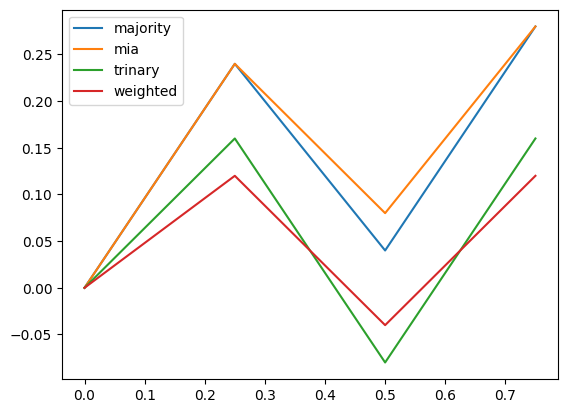

In [71]:
# Fit trees
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
trees = {}
for i,missing_prob in enumerate(missing_probs):
    print(missing_prob)
    X_train = dfs[i].loc[~dfs[i]['test'],features]
    y_train = dfs[i].loc[~dfs[i]['test'],'y']
    X_test  = dfs[i].loc[dfs[i]['test'],features]
    y_test  = dfs[i].loc[dfs[i]['test'],'y']
    trees[i] = {}
    for tree_name in tree_types:
        trees[i][tree_name] = copy.deepcopy(tree_types[tree_name])
        trees[i][tree_name].fit(X_train,y_train)

        y_hat = trees[i][tree_name].predict(X_test)
        if y_test.dtype == 'object':
            loss = (y_test!=y_hat).mean()
        else:
            loss = (y_test-y_hat).pow(2).mean()
        results.loc[missing_prob,tree_name] = loss
        print(tree_name)

(results-results.loc[0]).plot()

0
majority
mia
trinary
weighted
0.25
majority
mia
trinary
weighted
0.5
majority
mia
trinary
weighted
0.75
majority
mia
trinary
weighted


<Axes: >

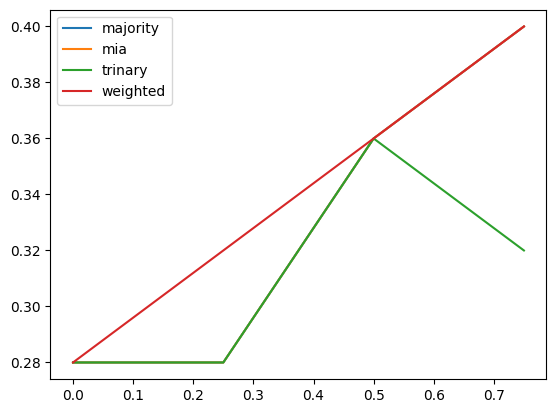

In [72]:
# Missingness of different frequencies ONLY in test data
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
for i,missing_prob in enumerate(missing_probs):
    X_test  = dfs[i].loc[dfs[i]['test'],features]
    y_test  = dfs[i].loc[dfs[i]['test'],'y']
    print(missing_prob)
    for tree_name in tree_types:
        y_hat = trees[0][tree_name].predict(X_test)
        if y_test.dtype == 'object':
            loss = (y_test!=y_hat).mean()
        else:
            loss = (y_test-y_hat).pow(2).mean()
        results.loc[missing_prob,tree_name] = loss
        print(tree_name)

results.plot()